IMPORTING THE REQUIRED PACKAGES

In [419]:
import numpy as np
import tensorflow as tf

np.random.seed(42)
tf.random.set_seed(42)


In [420]:

import pandas as pd
import matplotlib.pyplot as plt
# import numpy as np
# import tensorflow as tf
import keras
import os
import glob
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import math

import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
#from keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN, Dropout
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import model_from_json
from keras import optimizers

In [421]:
dir = 'dataset'
listdir = os.listdir(dir)

print(listdir)
print("The number of dataset :", len(listdir))

['B05_discharge_soh.csv', 'B07_discharge_soh.csv', 'B18_discharge_soh.csv', 'B33_discharge_soh.csv', 'B34_discharge_soh.csv', 'B46_discharge_soh.csv', 'B47_discharge_soh.csv', 'B48_discharge_soh.csv']
The number of dataset : 8


In [422]:
num = ['B05', 'B07', 'B18', 'B33', 'B34', 'B46', 'B47', 'B48']
for i in range(len(listdir)):
    vector = np.zeros((1,3))
    path = os.path.join(os.getcwd(), 'dataset/', num[i] + '_discharge_soh.csv')
    csv = pd.read_csv(path)
    df = pd.DataFrame(csv)
    
    vec = df[['cycle', 'capacity', 'SOH']]
    
    globals()['data_{}'.format(num[i])] = vec

In [423]:
data = pd.read_csv('dataset/B05_discharge_soh.csv')
df = pd.DataFrame(data)
df

,terminal_voltage,terminal_current,temperature,charge_current,charge_voltage,time,capacity,cycle,SOH
0,4.191492,-0.004902,24.330034,-0.0006,0.000,0.000,1.856487,1,0.928244
1,4.190749,-0.001478,24.325993,-0.0006,4.206,16.781,1.856487,1,0.928244
2,3.974871,-2.012528,24.389085,-1.9982,3.062,35.703,1.856487,1,0.928244
3,3.951717,-2.013979,24.544752,-1.9982,3.030,53.781,1.856487,1,0.928244
4,3.934352,-2.011144,24.731385,-1.9982,3.011,71.922,1.856487,1,0.928244
...,...,...,...,...,...,...,...,...,...
50280,3.579262,-0.001569,34.864823,0.0006,0.000,2781.312,1.325079,168,0.662540
50281,3.581964,-0.003067,34.814770,0.0006,0.000,2791.062,1.325079,168,0.662540
50282,3.584484,-0.003079,34.676258,0.0006,0.000,2800.828,1.325079,168,0.662540
50283,3.587336,0.001219,34.565580,0.0006,0.000,2810.640,1.325079,168,0.662540


In [424]:
data_B05

,cycle,capacity,SOH
0,1,1.856487,0.928244
1,1,1.856487,0.928244
2,1,1.856487,0.928244
3,1,1.856487,0.928244
4,1,1.856487,0.928244
...,...,...,...
50280,168,1.325079,0.662540
50281,168,1.325079,0.662540
50282,168,1.325079,0.662540
50283,168,1.325079,0.662540


In [425]:
for i in range(len(listdir)):
    print("Shape of data :", np.shape(globals()['data_{}'.format(num[i])]))

Shape of data : (50285, 3)
Shape of data : (50285, 3)
Shape of data : (34866, 3)
Shape of data : (42200, 3)
Shape of data : (45909, 3)
Shape of data : (23478, 3)
Shape of data : (23478, 3)
Shape of data : (23478, 3)


In [426]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
data_B46[["cycle", "capacity"]] = scaler.fit_transform(data_B46[["cycle", "capacity"]])


In [427]:
print(listdir)
dataset = data_B46[["cycle", "capacity", "SOH"]].values
cycle = data_B46['cycle']

dataset = np.array(dataset)
#dataset = dataset.reshape((len(dataset),1))
dataset.shape

['B05_discharge_soh.csv', 'B07_discharge_soh.csv', 'B18_discharge_soh.csv', 'B33_discharge_soh.csv', 'B34_discharge_soh.csv', 'B46_discharge_soh.csv', 'B47_discharge_soh.csv', 'B48_discharge_soh.csv']


(23478, 3)

CREATING TESTS AND TRAIN DATASETS

In [428]:
train_size = int(len(dataset) * 0.8)
# train_size = int(len(dataset) * 0.5)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

18782 4696


In [429]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), :-1]
        dataX.append(a)
        dataY.append(dataset[i + look_back, -1])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

In [430]:
def create_dataset_no_lookback(dataset):
    # Inputs: all columns except the last one (cycle and capacity)
    dataX = dataset[:, :-1]
    
    # Target: the last column (SOH)
    dataY = dataset[:, -1]
    
    return np.array(dataX), np.array(dataY)


In [431]:
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

18779
4693


In [432]:
# Assuming `dataset` has been preprocessed and contains [cycle, capacity, SoH]
# dataX, dataY = create_dataset_no_lookback(dataset)

# # Split into training and testing sets
# train_size = int(len(dataX) * 0.5)
# trainX, testX = dataX[:train_size], dataX[train_size:]
# trainY, testY = dataY[:train_size], dataY[train_size:]

# print("TrainX shape:", trainX.shape)
# print("TrainY shape:", trainY.shape)
# print("TestX shape:", testX.shape)
# print("TestY shape:", testY.shape)


In [433]:

# #for cnn SoH cycle capacity and lookback
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], trainX.shape[2]))
testX = np.reshape(testX, (testX.shape[0], trainX.shape[1], testX.shape[2]))
print(trainX)
print(testX.shape)

[[[0.         1.        ]
  [0.         1.        ]
  [0.         1.        ]]

 [[0.         1.        ]
  [0.         1.        ]
  [0.         1.        ]]

 [[0.         1.        ]
  [0.         1.        ]
  [0.         1.        ]]

 ...

 [[0.77142857 0.22483475]
  [0.77142857 0.22483475]
  [0.77142857 0.22483475]]

 [[0.77142857 0.22483475]
  [0.77142857 0.22483475]
  [0.77142857 0.22483475]]

 [[0.77142857 0.22483475]
  [0.77142857 0.22483475]
  [0.77142857 0.22483475]]]
(4693, 3, 2)


In [434]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

# Ensure trainX and testX have the shape (samples, time steps, features)
print(trainX.shape)  # Should be (samples, 1, features)
print(testX.shape)   # Should be (samples, 1, features)

# CNN Model
model = Sequential()
#for soh,cap,cycle,lookback
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2])))
#for soh,cap,cyc, no lookback
#model.add(Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=(1,2)))

model.add(MaxPooling1D(pool_size=2))  # Note: pool_size=1 since we have only 1 time step
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))

model.compile(loss='mae', optimizer='adam')

history = model.fit(trainX, trainY, epochs=100, batch_size=20, validation_data=(testX, testY), verbose=1, shuffle=False)



(18779, 3, 2)
(4693, 3, 2)
Epoch 1/100


c:\Users\sidar\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


939/939 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0887 - val_loss: 0.0255
Epoch 2/100
939/939 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0194 - val_loss: 0.0220
Epoch 3/100
939/939 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0135 - val_loss: 0.0208
Epoch 4/100
939/939 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0092 - val_loss: 0.0207
Epoch 5/100
939/939 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0134 - val_loss: 0.0195
Epoch 6/100
939/939 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0106 - val_loss: 0.0211
Epoch 7/100
939/939 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0091 - val_loss: 0.0187
Epoch 8/100
939/939 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0062 - val_loss: 0.0144
Epoch 9/100
939/939 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0053 - val_loss: 0.0148
Epoch 10/100
939/939 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0052 - val_loss: 0.0148
Epoch 11/100
939/939 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0051 - val_loss: 0.0137
Epoch 12/100
939/939 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

In [435]:
# save model architecture
# save model architecture
#model_json = model.to_json()
#open('50%/model/B05_model.json', 'w').write(model_json)

# save model's learned weights
#model.save_weights('50%/model/B05_weights.weights.h5', overwrite=True)

In [436]:
from keras.models import model_from_json 

#json_file = open("50%/model/B05_model.json", "r")
#loaded_model_json = json_file.read() 
#json_file.close()
#loaded_model = model_from_json(loaded_model_json)
 
# model weight load 
#loaded_model.load_weights("50%/model/B05_weights.weights.h5")
#print("Loaded model from disk")

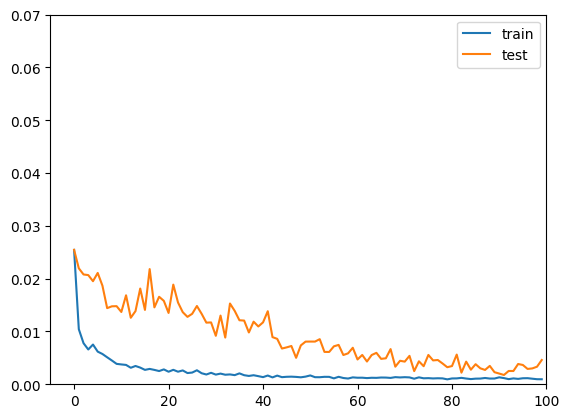

In [437]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.axis([-5, 100, 0, 0.07])
plt.legend() 
plt.show()

147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step
587/587 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step


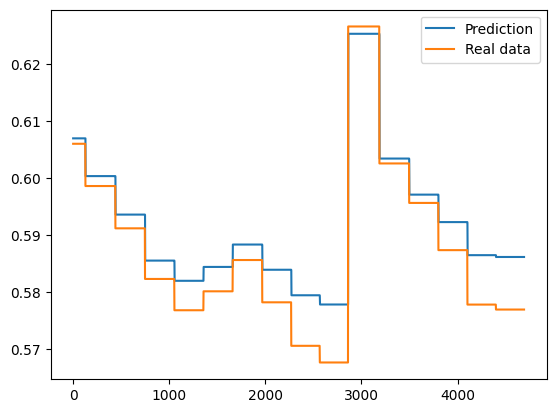

In [438]:
yhat = model.predict(testX)
tyhat = model.predict(trainX)
plt.plot(yhat, label='Prediction')
plt.plot(testY, label='Real data')
plt.legend()
plt.show()

147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step
587/587 ━━━━━━━━━━━━━━━━━━━━ 1s 896us/step


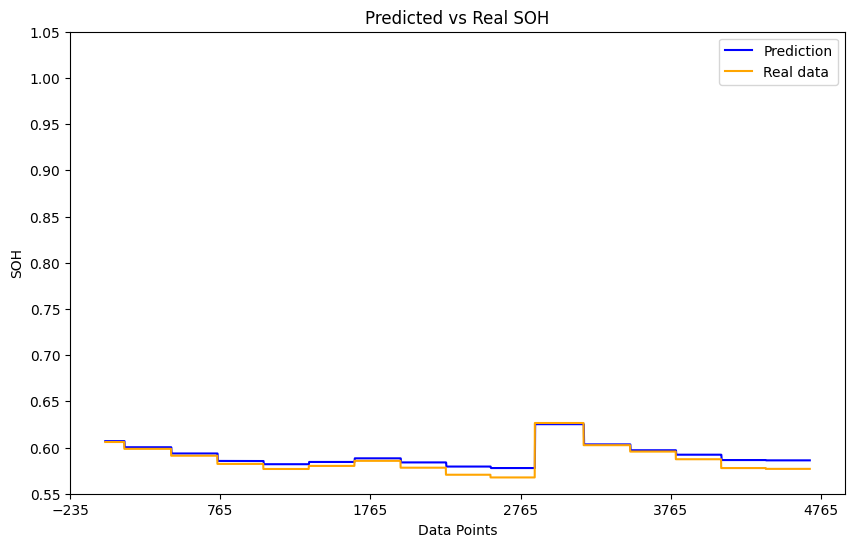

In [439]:
import numpy as np

# Predict using the model
yhat = model.predict(testX)
tyhat = model.predict(trainX)

# Plot predictions vs real data
plt.figure(figsize=(10, 6))  # Optional: Adjust figure size for better readability
plt.plot(yhat, label='Prediction', color='blue')
plt.plot(testY, label='Real data', color='orange')
plt.legend()

# Set y-axis ticks at intervals of 0.05, ensuring 10 intervals
y_min = min(min(yhat), min(testY))  # Minimum value from predictions and actual data
y_max = max(max(yhat), max(testY))  # Maximum value from predictions and actual data

# Adjust limits to ensure at least 10 intervals
y_min = np.floor(y_min / 0.05) * 0.05
y_max = np.ceil(y_max / 0.05) * 0.05
if (y_max - y_min) < 0.5:  # Ensure at least 10 intervals of 0.05
    y_max = y_min + 0.5
plt.ylim(y_min, y_max)

# Set y-axis ticks at intervals of 0.05
plt.yticks(np.arange(y_min, y_max + 0.05, 0.05))

# Set x-axis ticks at intervals of 1000
x_min, x_max = plt.xlim()  # Get current x-axis limits
plt.xticks(np.arange(x_min, x_max, 1000))

# Add labels and title
plt.xlabel('Data Points')
plt.ylabel('SOH')
plt.title('Predicted vs Real SOH')

plt.show()


In [440]:
print("Shape of train data :", trainX.shape)
print("Shape of prediction :", yhat.shape)
print("Shape of real data :", testY.shape)
print(yhat)

Shape of train data : (18779, 3, 2)
Shape of prediction : (4693, 1)
Shape of real data : (4693,)
[[0.60692334]
 [0.60692334]
 [0.60692334]
 ...
 [0.58612   ]
 [0.58612   ]
 [0.58612   ]]


In [441]:
rmse = math.sqrt(mean_squared_error(testY, yhat))
mae = mean_absolute_error(testY, yhat)
print('Test RMSE: %.3f' % rmse)
print('Test MAE: %.3f' % mae)

Test RMSE: 0.006
Test MAE: 0.005


In [442]:
from sklearn.metrics import r2_score
r2 = r2_score(testY, yhat)
print('Test R² Score: %.3f' % r2)


Test R² Score: 0.856


In [443]:
mape = np.mean(np.abs((testY - yhat) / testY)) * 100
print('Test MAPE: %.3f' % mape)


Test MAPE: 2.542


In [444]:
from sklearn.metrics import median_absolute_error
med_ae = median_absolute_error(testY, yhat)
print('Test Median Absolute Error: %.3f' % med_ae)


Test Median Absolute Error: 0.004
